In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')
from datetime import date, datetime

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, classification_report, precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Загружаем данные из data_train при помощи pandas и features c помощью dask.dataframe

In [2]:
data_train = pd.read_csv('data_train.csv')
data_train.head(4)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0


In [3]:
data_train = data_train.drop('Unnamed: 0', axis=1)

In [4]:
features = dd.read_csv('features.csv', sep='\t')
features.head(4)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0


In [5]:
features = features.drop('Unnamed: 0', axis=1)

## Обработка данных из data_train

Новый признак date будет содержать данные из buy_time в удобном формате

In [6]:
data_train['date'] = data_train['buy_time'].apply(lambda x: date.fromtimestamp(x))
data_train.head(4)

,id,vas_id,buy_time,target,date
0,540968,8.0,1537131600,0.0,2018-09-17
1,1454121,4.0,1531688400,0.0,2018-07-16
2,2458816,1.0,1534107600,0.0,2018-08-13
3,3535012,5.0,1535922000,0.0,2018-09-03


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  int64  
 3   target    831653 non-null  float64
 4   date      831653 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 31.7+ MB


In [8]:
print(f'Первое предложение: {data_train["date"].min()} Последнее предложение: {data_train["date"].max()}')

Первое предложение: 2018-07-09 Последнее предложение: 2018-12-31


In [9]:
# пользователи, которым предлагали подключение услуг больше 1 раза
data_train['id'].value_counts().sort_values(ascending=False)

1347260    3
17679      3
340716     3
1596002    3
1195576    3
          ..
1934276    1
4340166    1
2891727    1
66499      1
3022610    1
Name: id, Length: 806613, dtype: int64

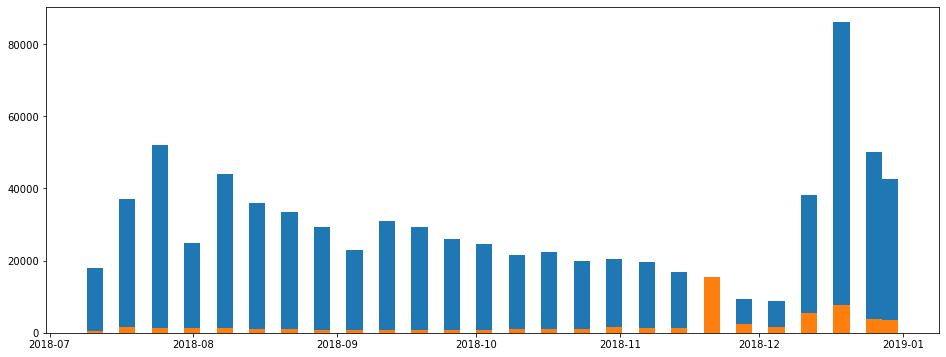

In [10]:
plt.figure(figsize=(16, 6))
plt.hist(data_train.loc[(data_train['target']==0, 'date')], bins=50)
plt.hist(data_train.loc[(data_train['target']==1, 'date')], bins=50)
plt.show();

В ноябре количество пользователей подключивших услуг превышает тех, кто от нее отказался.
В ноябре и декабре наибольшее количество положительных откликов на подключение услуг.

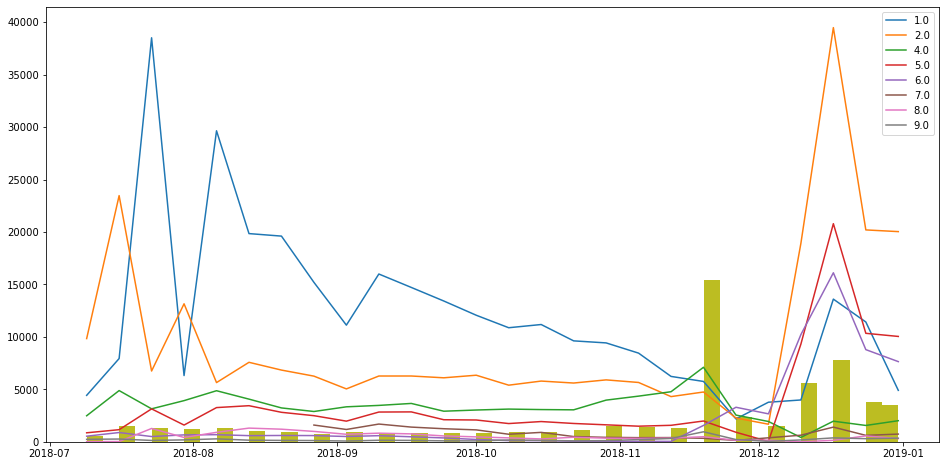

In [11]:
plt.figure(figsize=(16, 8))
for i in sorted(list(data_train['vas_id'].unique())):
    plt.plot(data_train.loc[(data_train['vas_id'] == i, 'date') ].value_counts().sort_index(), label=i)
plt.hist(data_train.loc[(data_train['target'] == 1, 'date') ], bins=50)
plt.legend()
plt.show();

Услуги 1 и 2 в начале года предлагались чаще всего, но постепенно предложение падало, а в декабре произошёл резкий скачок предложения услуг 1, 2, 5 и 6, при этом предложение по услуге 4 пошло на резкий спад.

### Целевая переменная

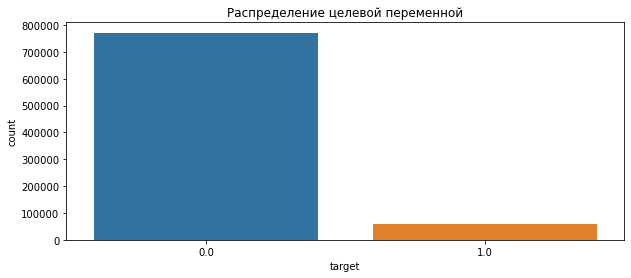

In [12]:
plt.figure(figsize=(10, 4))
sns.countplot(x='target', data=data_train)
plt.title('Распределение целевой переменной')
plt.show()

Наблюдается сильный дисбаланс

### Объединение data_train с features

In [13]:
# удалим из features тех пользователей, которых нет в data_train
ids = data_train['id'].unique()
features = features.compute()
features = features.loc[(features['id'].isin(ids))]

In [14]:
features.head(4)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
13,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
19,2070757,1540760400,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
20,2071522,1544994000,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [15]:
# отсортируем данные по признаку buy_time
data_train = data_train.sort_index().sort_values(by='buy_time')
features = features.sort_values(by='buy_time')

In [16]:
data_train = pd.merge_asof(data_train, features, on='buy_time', by='id', direction='nearest')

Выделим день, неделю и месяц предложения услуг в отдельные признаки

In [17]:
data_train['day'] = data_train['date'].apply(lambda x: pd.to_datetime(x).day)
data_train['week'] = data_train['date'].apply(lambda x: pd.to_datetime(x).day // 7)
data_train['month'] = data_train['date'].apply(lambda x: pd.to_datetime(x).month)

In [18]:
data_train = data_train.drop('buy_time', axis=1)
data_train = data_train.drop('date', axis=1)

In [19]:
data_train[data_train.select_dtypes(np.float64).columns] = data_train.select_dtypes(np.float64).astype(np.float32)

In [20]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Columns: 259 entries, id to month
dtypes: float32(255), int64(4)
memory usage: 840.7 MB


In [21]:
data_train.head(4)

,id,vas_id,target,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,day,week,month
0,2582523,2.0,0.0,314.560028,9.290888,342.989227,7.523202,337.571747,-13.581790,-16.08618,...,121.369553,142.252274,-16.832888,-0.694429,-11.175933,-0.45614,0.0,9,1,7
1,1292549,2.0,0.0,93.880028,-217.499115,79.939217,-270.106812,74.521751,-291.211792,-16.08618,...,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,9,1,7
2,4053116,1.0,0.0,125.110031,152.190887,111.169212,107.213203,105.751755,86.108208,-16.08618,...,761.369568,-213.747726,26.167112,-0.694429,39.824066,-0.45614,1.0,9,1,7
3,4158361,2.0,0.0,-7.829971,-266.839111,-20.500786,-304.196808,-25.918247,-325.301788,-16.08618,...,-37.630447,-108.747726,-25.832888,-0.694429,-12.175933,-0.45614,1.0,9,1,7


In [22]:
data_train.to_csv('train_data_features.csv', index=False)

## Обработка данных из data_test

In [23]:
data_test = pd.read_csv('data_test.csv')
data_test = data_test.drop('Unnamed: 0', axis=1)
data_test['date'] = data_test['buy_time'].apply(lambda x: date.fromtimestamp(x))
data_test.head(4)

,id,vas_id,buy_time,date
0,3130519,2.0,1548018000,2019-01-21
1,2000860,4.0,1548018000,2019-01-21
2,1099444,2.0,1546808400,2019-01-07
3,1343255,5.0,1547413200,2019-01-14


In [24]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        71231 non-null  int64  
 1   vas_id    71231 non-null  float64
 2   buy_time  71231 non-null  int64  
 3   date      71231 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 2.2+ MB


In [25]:
features_test = dd.read_csv('features.csv', sep='\t')
features_test = features_test.drop('Unnamed: 0', axis=1)

# удалим из features тех пользователей, которых нет в data_test
ids_test = data_test['id'].unique()
features_test = features_test.compute()
features_test = features_test.loc[(features_test['id'].isin(ids_test))]

# отсортируем данные по признаку buy_time
data_test = data_test.sort_index().sort_values(by='buy_time')
features_test = features_test.sort_values(by='buy_time')

data_test = pd.merge_asof(data_test, features_test, on='buy_time', by='id', direction='nearest')

# Выделим день, неделю и месяц предложения услуг в отдельные признаки
data_test['day'] = data_test['date'].apply(lambda x: pd.to_datetime(x).day)
data_test['week'] = data_test['date'].apply(lambda x: pd.to_datetime(x).day // 7)
data_test['month'] = data_test['date'].apply(lambda x: pd.to_datetime(x).month)

data_test = data_test.drop('buy_time', axis=1)
data_test = data_test.drop('date', axis=1)

data_test[data_test.select_dtypes(np.float64).columns] = data_test.select_dtypes(np.float64).astype(np.float32)
data_test.head(4)

,id,vas_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,day,week,month
0,2905850,5.0,326.930023,227.410889,312.989227,200.223206,307.571747,179.118210,-16.08618,-65.076096,...,-18.630449,-209.747726,-15.832889,-0.694429,-2.175933,-0.45614,0.0,7,1,1
1,31619,2.0,-96.799973,100.290886,-62.040787,250.953201,-67.458244,229.848206,-16.08618,-65.076096,...,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,7,1,1
2,1427271,6.0,-87.299973,-368.999115,339.439209,48.733200,334.021759,27.628210,-16.08618,-65.076096,...,-37.630447,116.252274,25.167112,-0.694429,38.824066,-0.45614,0.0,7,1,1
3,2162521,6.0,-96.799973,-20.459112,-110.740784,-34.936798,-116.158249,-56.041790,-16.08618,-65.076096,...,-37.630447,-298.747711,-24.832888,-0.694429,-11.175933,-0.45614,0.0,7,1,1


In [26]:
data_test.to_csv('test_data_features.csv', index=False)

**Разделим признаки и целевую переменную**

In [27]:
data_train = pd.read_csv('train_data_features.csv')
data_train.head(4)

,id,vas_id,target,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,day,week,month
0,2582523,2.0,0.0,314.560030,9.290888,342.989230,7.523202,337.571750,-13.58179,-16.08618,...,121.369550,142.25227,-16.832888,-0.694429,-11.175933,-0.45614,0.0,9,1,7
1,1292549,2.0,0.0,93.880030,-217.499110,79.939220,-270.106800,74.521750,-291.21180,-16.08618,...,-37.630447,-306.74770,-25.832888,-0.694429,-12.175933,-0.45614,0.0,9,1,7
2,4053116,1.0,0.0,125.110030,152.190890,111.169210,107.213200,105.751755,86.10821,-16.08618,...,761.369570,-213.74773,26.167112,-0.694429,39.824066,-0.45614,1.0,9,1,7
3,4158361,2.0,0.0,-7.829971,-266.839100,-20.500786,-304.196800,-25.918247,-325.30180,-16.08618,...,-37.630447,-108.74773,-25.832888,-0.694429,-12.175933,-0.45614,1.0,9,1,7


In [28]:
X = data_train.drop('target', axis=1)
y = data_train['target']

**Определение типа признаков**

In [29]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))
X_nunique.shape

(258,)

In [30]:
f_all = set(X_nunique.index.tolist())
len(f_all)

258

In [31]:
# константные признаки
f_const = set(X_nunique[X_nunique == 1].index.tolist())
f_other = f_all - f_const
len(f_const), len(f_other)

(5, 253)

In [32]:
# вещественные признаки:
f_numeric = (X[f_other].fillna(0).astype(int).sum() - X[f_other].fillna(0).sum()).abs() 
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
f_other = f_other - f_numeric
len(f_numeric), len(f_other)

(244, 9)

In [33]:
# категориальные признаки
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_other = f_other - f_categorical
len(f_categorical), len(f_other)

(3, 6)

In [34]:
# Отберём бинарные признаки:
f_binary = set(X.loc[:, f_other].columns[(
    (X.loc[:, f_other].max() == 1) & \
    (X.loc[:, f_other].min() == 0) & \
    (X.loc[:, f_other].isnull().sum() == 0))])
f_other = f_other - f_binary
len(f_binary), len(f_other)

(0, 6)

In [35]:
f_numeric = f_numeric | f_other
f_other = f_other - f_numeric
len(f_other)

0

In [36]:
assert(X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_categorical) + len(f_numeric))

In [37]:
print('f_all:', len(f_all))
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 258

f_const: 5
f_binary: 0
f_categorical: 3
f_numeric: 250


### Разобьем данные на train и test

In [38]:
train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=42)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

**Балансировка данных**

In [39]:
data_balance = RandomUnderSampler(random_state=42)
X_train, y_train = data_balance.fit_resample(X_train, y_train)

print('Train')
print(y_train.value_counts() / y_train.shape[0])
print()
print('Test')
print(y_test.value_counts() / y_test.shape[0])

Train
0.0    0.5
1.0    0.5
Name: target, dtype: float64

Test
0.0    0.92811
1.0    0.07189
Name: target, dtype: float64


### Построение пайплайнов

**Column Selector**

In [40]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(f'DataFrame не содержит следующие колонки: {cols_error}')

**Пайплайн для обработки признаков**

In [41]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ('numeric_features', make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            PCA()
        )),
        ('categorical_features', make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ('boolean_features', make_pipeline(
            ColumnSelector(f_binary)
        ))
    ])
)

f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['vas_id', '32', '248', 'day', '244', 'month', '38',
                          '115', '249', '193', '132', '3', '133', '136', '159',
                          '215', '91', '120', '116', '216', '17', '70', '176',
                          '71', '100', '235', '14', '170', '80', '227', ...])),
 ('featureunion',
  FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['32',
                                                                           '248',
                                                                           'day',
                                                                           '244',
                                                                           '38',
                                                                           '115',
                                

In [42]:
X_test.shape[1]

258

In [43]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

269

**Подбор параметров с помощью GridSearchCV**

In [44]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print('Best %s score: %.2f' % (scoring, gsc.best_score_))
    print()
    print('Best parameters set found on development set:')
    print()
    print(gsc.best_params_)
    print()
    print('Grid scores on development set:')
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print('%0.3f (+/-%0.03f) for %r'
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [45]:
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

## Обучение моделей

In [46]:
def treshold_search(y_true, y_pred):
    top = [0.5, f1_score(y_true, y_pred[: , 1] > 0.5, average='macro')]
    for treshold in np.linspace(0, 1, 20):
        fscore = f1_score(y_true, y_pred[: , 1] > treshold, average='macro')
        if fscore > top[1]:
            top[0] = treshold
            top[1] = fscore
    print(f'Лучшая отсечка : {top[0]}, Метрика F1_macro: {top[1]}')
    print("=" * 80)
    print(classification_report(y_true, y_pred[:, 1] > top[0]))

### ***1) LogisticRegression***

In [47]:
lgr_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=42)
)

In [48]:
lgr_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['vas_id', '32', '248',
                                                          'day', '244', 'month',
                                                          '38', '115', '249',
                                                          '193', '132', '3',
                                                          '133', '136', '159',
                                                          '215', '91', '120',
                                                          '116', '216', '17',
                                                          '70', '176', '71',
                                                          '100', '235', '14',
                                                          '170', '80', '227', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_f

In [49]:
preds = lgr_pipe.predict(X_test)

In [50]:
f1_score(y_test, preds, average='macro')

0.6884021484640246

In [51]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91    192967
         1.0       0.31      0.91      0.46     14947

    accuracy                           0.85    207914
   macro avg       0.65      0.88      0.69    207914
weighted avg       0.94      0.85      0.88    207914



Попробуем подобрать лучшие параметры для модели

In [52]:
%%time

param_grid = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.01, 0.1, 5.0]
}

lgr_gsc = run_grid_search(lgr_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.91

Best parameters set found on development set:

{'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

Grid scores on development set:

nan (+/-nan) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1'}
0.905 (+/-0.002) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
0.907 (+/-0.002) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l1'}
0.907 (+/-0.002) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

Wall time: 2min 12s


Best roc_auc score: 0.91

Best parameters set found on development set:

{'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

Wall time: 2min 12s

In [53]:
lgr_gsc.best_params_

{'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

In [54]:
lgr_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', C=5.0, random_state=42)),
    LogisticRegression(random_state=42)
)

In [55]:
%%time

param_grid = [
    {'selectfrommodel__max_features': [None, 5, 10, 50, 100, 150], 'selectfrommodel__threshold': [-np.inf]},
    {'selectfrommodel__threshold': [1e-5]},
]

lgr_fs_gsc = run_grid_search(lgr_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.91

Best parameters set found on development set:

{'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.907 (+/-0.002) for {'selectfrommodel__max_features': None, 'selectfrommodel__threshold': -inf}
0.896 (+/-0.003) for {'selectfrommodel__max_features': 5, 'selectfrommodel__threshold': -inf}
0.902 (+/-0.001) for {'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}
0.906 (+/-0.002) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.907 (+/-0.002) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.907 (+/-0.002) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.907 (+/-0.002) for {'selectfrommodel__threshold': 1e-05}

Wall time: 2min 51s


Best roc_auc score: 0.91

Best parameters set found on development set:

{'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}

Wall time: 2min 51s

Оптимальнее всего использовать топ-150 признаков

In [56]:
lgr_fs_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['vas_id', '32', '248',
                                                          'day', '244', 'month',
                                                          '38', '115', '249',
                                                          '193', '132', '3',
                                                          '133', '136', '159',
                                                          '215', '91', '120',
                                                          '116', '216', '17',
                                                          '70', '176', '71',
                                                          '100', '235', '14',
                                                          '170', '80', '227', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_f

In [57]:
preds_train_lgr = lgr_fs_pipe.predict(X_train)
f1_score(y_train, preds_train_lgr, average='macro')

0.8759852935478104

In [58]:
preds_test_lgr = lgr_fs_pipe.predict(X_test)
f1_score(y_test, preds_test_lgr, average='macro')

0.6854093413908482

In [59]:
preds_proba_train_lgr = lgr_fs_pipe.predict_proba(X_train)

In [60]:
preds_proba_test_lgr = lgr_fs_pipe.predict_proba(X_test)

In [61]:
treshold_search(y_train, preds_proba_train_lgr)

Лучшая отсечка : 0.5789473684210527, Метрика F1_macro: 0.8838700659982848
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88     45239
         1.0       0.87      0.90      0.89     45239

    accuracy                           0.88     90478
   macro avg       0.88      0.88      0.88     90478
weighted avg       0.88      0.88      0.88     90478



In [62]:
treshold_search(y_test, preds_proba_test_lgr)

Лучшая отсечка : 0.6842105263157894, Метрика F1_macro: 0.7274920405499081
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    192967
         1.0       0.38      0.83      0.52     14947

    accuracy                           0.89    207914
   macro avg       0.68      0.86      0.73    207914
weighted avg       0.94      0.89      0.91    207914



### ***2) LGBMClassifier***

In [63]:
lgbm_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', C=5.0, random_state=42)),
    LGBMClassifier(random_state=42)
)

In [64]:
%%time

param_grid = [
    {
     'lgbmclassifier__n_estimators' : [100, 200, 300]     
    }     
]

lgbm_gsc = run_grid_search(lgbm_fs_pipe, X_train, y_train, param_grid, kfold_cv, scoring='f1')

Best f1 score: 0.89

Best parameters set found on development set:

{'lgbmclassifier__n_estimators': 100}

Grid scores on development set:

0.890 (+/-0.004) for {'lgbmclassifier__n_estimators': 100}
0.889 (+/-0.004) for {'lgbmclassifier__n_estimators': 200}
0.889 (+/-0.004) for {'lgbmclassifier__n_estimators': 300}

Wall time: 1min 22s


Best f1 score: 0.89

Best parameters set found on development set:

{'lgbmclassifier__n_estimators': 100}

Wall time: 1min 22s

In [65]:
lgbm_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', C=5.0, random_state=42)),
    LGBMClassifier(random_state=42, n_estimators=100)
)

In [66]:
lgbm_fs_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['vas_id', '32', '248',
                                                          'day', '244', 'month',
                                                          '38', '115', '249',
                                                          '193', '132', '3',
                                                          '133', '136', '159',
                                                          '215', '91', '120',
                                                          '116', '216', '17',
                                                          '70', '176', '71',
                                                          '100', '235', '14',
                                                          '170', '80', '227', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_f

In [67]:
preds_train_lgbm = lgbm_fs_pipe.predict(X_train)
f1_score(y_train, preds_train_lgbm, average='macro')

0.8877396398368465

In [68]:
preds_test_lgbm = lgbm_fs_pipe.predict(X_test)
f1_score(y_test, preds_test_lgbm, average='macro')

0.7135191202137183

In [69]:
preds_proba_train_lgbm = lgbm_fs_pipe.predict_proba(X_train)

In [70]:
preds_proba_test_lgbm = lgbm_fs_pipe.predict_proba(X_test)

In [71]:
treshold_search(y_train, preds_proba_train_lgbm)

Лучшая отсечка : 0.631578947368421, Метрика F1_macro: 0.8889420035825384
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89     45239
         1.0       0.88      0.91      0.89     45239

    accuracy                           0.89     90478
   macro avg       0.89      0.89      0.89     90478
weighted avg       0.89      0.89      0.89     90478



In [72]:
treshold_search(y_test, preds_proba_test_lgbm)

Лучшая отсечка : 0.8421052631578947, Метрика F1_macro: 0.7557860279975601
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96    192967
         1.0       0.48      0.66      0.55     14947

    accuracy                           0.92    207914
   macro avg       0.72      0.80      0.76    207914
weighted avg       0.94      0.92      0.93    207914



### ***3) CatBoostClassifier***

In [73]:
cb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', C=5.0, random_state=42)),
    CatBoostClassifier(random_state=42)
)

In [74]:
%%time

param_grid = {
     'selectfrommodel__threshold': [-np.inf, 1e-05],
    'catboostclassifier__depth': [1, 5],
    'catboostclassifier__n_estimators': [10, 100]     
    }

cb_fs_gsc = run_grid_search(cb_fs_pipe, X_train, y_train, param_grid, kfold_cv, scoring='f1')

Learning rate set to 0.5
0:	learn: 0.4009584	total: 229ms	remaining: 2.06s
1:	learn: 0.3483566	total: 291ms	remaining: 1.16s
2:	learn: 0.3287738	total: 353ms	remaining: 823ms
3:	learn: 0.3261733	total: 416ms	remaining: 624ms
4:	learn: 0.3238246	total: 472ms	remaining: 472ms
5:	learn: 0.3226356	total: 534ms	remaining: 356ms
6:	learn: 0.3221669	total: 595ms	remaining: 255ms
7:	learn: 0.3214706	total: 648ms	remaining: 162ms
8:	learn: 0.3211213	total: 712ms	remaining: 79.1ms
9:	learn: 0.3206024	total: 777ms	remaining: 0us
Best f1 score: 0.89

Best parameters set found on development set:

{'catboostclassifier__depth': 5, 'catboostclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.874 (+/-0.002) for {'catboostclassifier__depth': 1, 'catboostclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.874 (+/-0.002) for {'catboostclassifier__depth': 1, 'catboostclassifier__n_estimators': 10, 'selectfrommodel__threshold': 1e-05}
0.88

Best f1 score: 0.89

Best parameters set found on development set:

{'catboostclassifier__depth': 5, 'catboostclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}

Wall time: 3min 7s

In [75]:
cb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', C=5.0, random_state=42)),
    CatBoostClassifier(random_state=42, depth=5, n_estimators=10)
)

In [76]:
cb_fs_pipe.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.4008689	total: 18.2ms	remaining: 164ms
1:	learn: 0.3483535	total: 30.6ms	remaining: 122ms
2:	learn: 0.3321941	total: 45.3ms	remaining: 106ms
3:	learn: 0.3289984	total: 56.8ms	remaining: 85.3ms
4:	learn: 0.3267811	total: 68ms	remaining: 68ms
5:	learn: 0.3257218	total: 79.8ms	remaining: 53.2ms
6:	learn: 0.3245426	total: 92.3ms	remaining: 39.5ms
7:	learn: 0.3235613	total: 104ms	remaining: 26ms
8:	learn: 0.3229119	total: 116ms	remaining: 12.9ms
9:	learn: 0.3226726	total: 148ms	remaining: 0us


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['vas_id', '32', '248',
                                                          'day', '244', 'month',
                                                          '38', '115', '249',
                                                          '193', '132', '3',
                                                          '133', '136', '159',
                                                          '215', '91', '120',
                                                          '116', '216', '17',
                                                          '70', '176', '71',
                                                          '100', '235', '14',
                                                          '170', '80', '227', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_f

In [77]:
preds_train_cb = cb_fs_pipe.predict(X_train)
f1_score(y_train, preds_train_cb, average='macro')

0.8872204174906528

In [78]:
preds_test_cb = cb_fs_pipe.predict(X_test)
f1_score(y_test, preds_test_cb, average='macro')

0.7135993200467083

In [79]:
preds_proba_train_cb = cb_fs_pipe.predict_proba(X_train)

In [80]:
preds_proba_test_cb = cb_fs_pipe.predict_proba(X_test)

In [81]:
treshold_search(y_train, preds_proba_train_cb)

Лучшая отсечка : 0.5789473684210527, Метрика F1_macro: 0.8873802198798362
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88     45239
         1.0       0.87      0.91      0.89     45239

    accuracy                           0.89     90478
   macro avg       0.89      0.89      0.89     90478
weighted avg       0.89      0.89      0.89     90478



In [82]:
treshold_search(y_test, preds_proba_test_cb)

Лучшая отсечка : 0.8421052631578947, Метрика F1_macro: 0.757281422901767
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96    192967
         1.0       0.49      0.65      0.56     14947

    accuracy                           0.93    207914
   macro avg       0.73      0.80      0.76    207914
weighted avg       0.94      0.93      0.93    207914



### Предсказания на тестовой выборке

***1) LogisticRegression***

In [83]:
lgr_fs_pipe_final = lgr_gsc.best_estimator_
lgr_fs_pipe_final.fit(X_train, y_train)
lgr_fs_pred = lgr_fs_pipe_final.predict_proba(X_test)[:, 1]

In [84]:
print(classification_report(y_test, lgr_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91    192967
         1.0       0.31      0.91      0.46     14947

    accuracy                           0.85    207914
   macro avg       0.65      0.88      0.69    207914
weighted avg       0.94      0.85      0.88    207914



***2) LGBMClassifier***

In [85]:
lgbm_fs_pipe_final = lgbm_gsc.best_estimator_
lgbm_fs_pipe_final.fit(X_train, y_train)
lgbm_fs_pred = lgbm_fs_pipe_final.predict_proba(X_test)[:, 1]

In [86]:
print(classification_report(y_test, lgbm_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    192967
         1.0       0.35      0.91      0.50     14947

    accuracy                           0.87    207914
   macro avg       0.67      0.89      0.71    207914
weighted avg       0.95      0.87      0.89    207914



***4) CatBoostClassifier***

In [87]:
cb_fs_pipe_final = cb_fs_gsc.best_estimator_
cb_fs_pipe_final.fit(X_train, y_train)
cb_fs_pred = cb_fs_pipe_final.predict_proba(X_test)[:, 1]

Learning rate set to 0.5
0:	learn: 0.4009584	total: 61.6ms	remaining: 554ms
1:	learn: 0.3483566	total: 117ms	remaining: 469ms
2:	learn: 0.3287738	total: 182ms	remaining: 424ms
3:	learn: 0.3261733	total: 243ms	remaining: 364ms
4:	learn: 0.3238246	total: 299ms	remaining: 299ms
5:	learn: 0.3226356	total: 361ms	remaining: 240ms
6:	learn: 0.3221669	total: 424ms	remaining: 182ms
7:	learn: 0.3214706	total: 487ms	remaining: 122ms
8:	learn: 0.3211213	total: 547ms	remaining: 60.8ms
9:	learn: 0.3206024	total: 611ms	remaining: 0us


In [88]:
print(classification_report(y_test, cb_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    192967
         1.0       0.35      0.91      0.50     14947

    accuracy                           0.87    207914
   macro avg       0.67      0.89      0.71    207914
weighted avg       0.95      0.87      0.89    207914



### Сравнение моделей

lgr_fs_pred: AUC_PR = 0.456
lgr_fs_pred: AUC_ROC = 0.909
lgbm_fs_pred: AUC_PR = 0.558
lgbm_fs_pred: AUC_ROC = 0.931
cb_fs_pred: AUC_PR = 0.559
cb_fs_pred: AUC_ROC = 0.930


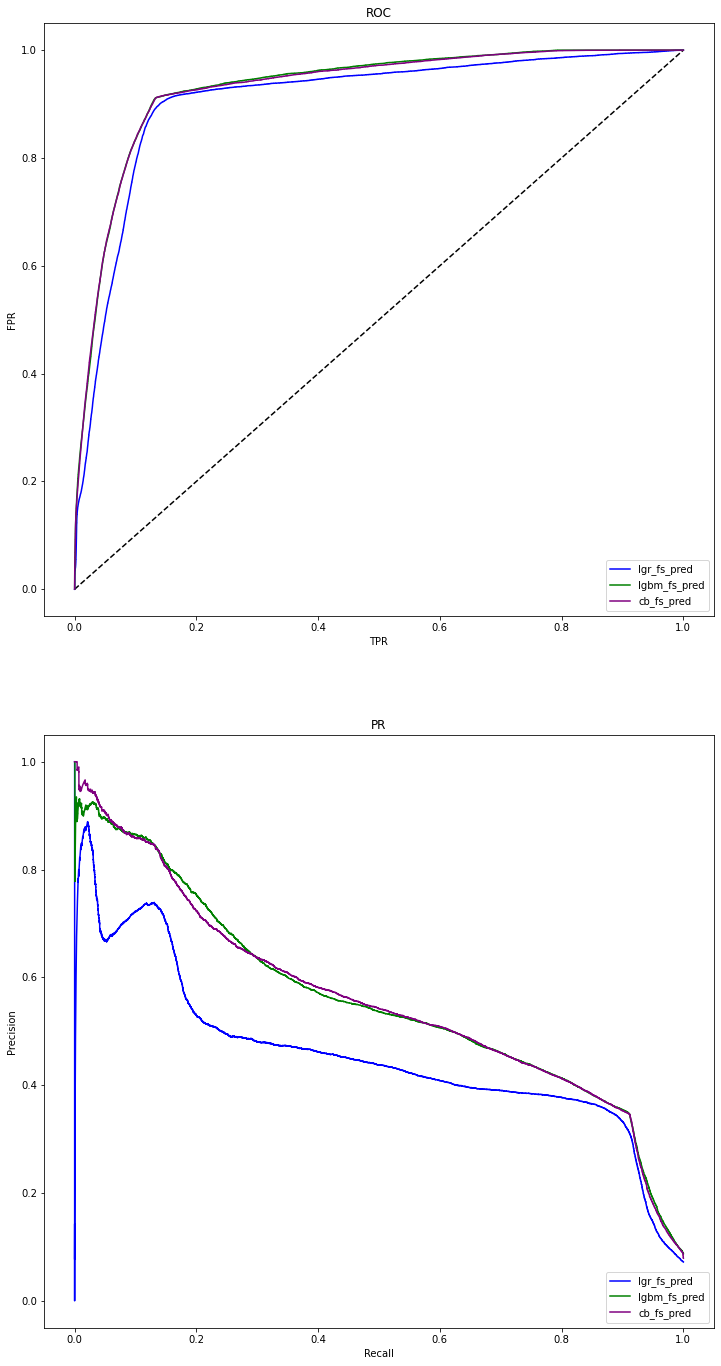

In [89]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')

ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, lgr_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lgr_fs_pred)
ax1.plot(fpr, tpr, label='lgr_fs_pred', color='b')
ax2.plot(recall, precision, label='lgr_fs_pred', color='b')
print('lgr_fs_pred: AUC_PR = %.3f' % auc(recall, precision))
print('lgr_fs_pred: AUC_ROC = %.3f' % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, lgbm_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lgbm_fs_pred)
ax1.plot(fpr, tpr, label='lgbm_fs_pred', color='g')
ax2.plot(recall, precision, label='lgbm_fs_pred', color='g')
print('lgbm_fs_pred: AUC_PR = %.3f' % auc(recall, precision))
print('lgbm_fs_pred: AUC_ROC = %.3f' % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, cb_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, cb_fs_pred)
ax1.plot(fpr, tpr, label='cb_fs_pred', color='purple')
ax2.plot(recall, precision, label='cb_fs_pred', color='purple')
print('cb_fs_pred: AUC_PR = %.3f' % auc(recall, precision))
print('cb_fs_pred: AUC_ROC = %.3f' % auc(fpr, tpr))

ax1.legend(loc='lower right')
ax2.legend(loc='lower right');

Лучше себя показали модели: LGBMClassifier и CatBoostClassifier. Выберем LGBMClassifier

**Сохраним модель**

In [90]:
with open('lgbm_fs_model.pickle', 'wb') as f:
    pickle.dump(lgbm_fs_pipe, f, protocol=pickle.HIGHEST_PROTOCOL)

### Предсказание на тестовой выборке

In [91]:
test_data = pd.read_csv('test_data_features.csv')
test_data.head(4)

,id,vas_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,day,week,month
0,2905850,5.0,326.93002,227.410890,312.989230,200.2232,307.571750,179.11821,-16.08618,-65.076096,...,-18.630450,-209.74773,-15.832889,-0.694429,-2.175933,-0.45614,0.0,7,1,1
1,31619,2.0,-96.79997,100.290886,-62.040787,250.9532,-67.458244,229.84820,-16.08618,-65.076096,...,-37.630447,-306.74770,-25.832888,-0.694429,-12.175933,-0.45614,0.0,7,1,1
2,1427271,6.0,-87.29997,-368.999100,339.439200,48.7332,334.021760,27.62821,-16.08618,-65.076096,...,-37.630447,116.25227,25.167112,-0.694429,38.824066,-0.45614,0.0,7,1,1
3,2162521,6.0,-96.79997,-20.459112,-110.740780,-34.9368,-116.158250,-56.04179,-16.08618,-65.076096,...,-37.630447,-298.74770,-24.832888,-0.694429,-11.175933,-0.45614,0.0,7,1,1


In [92]:
with open('lgbm_fs_model.pickle', 'rb') as f:
    lg_fs_model =  pickle.load(f)

In [93]:
y_pred = cb_fs_pipe_final.predict_proba(test_data)[:, 1]

In [94]:
X_test = pd.read_csv('data_test.csv')
X_test = X_test.drop('Unnamed: 0', axis=1)

In [95]:
X_test['target'] = y_pred

In [96]:
X_test.to_csv('answers_test.csv', index=False)

In [97]:
X_test.head(4)

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.120780
1,2000860,4.0,1548018000,0.162518
2,1099444,2.0,1546808400,0.859271
3,1343255,5.0,1547413200,0.853432
